# Cassava Leaf Disease Classification

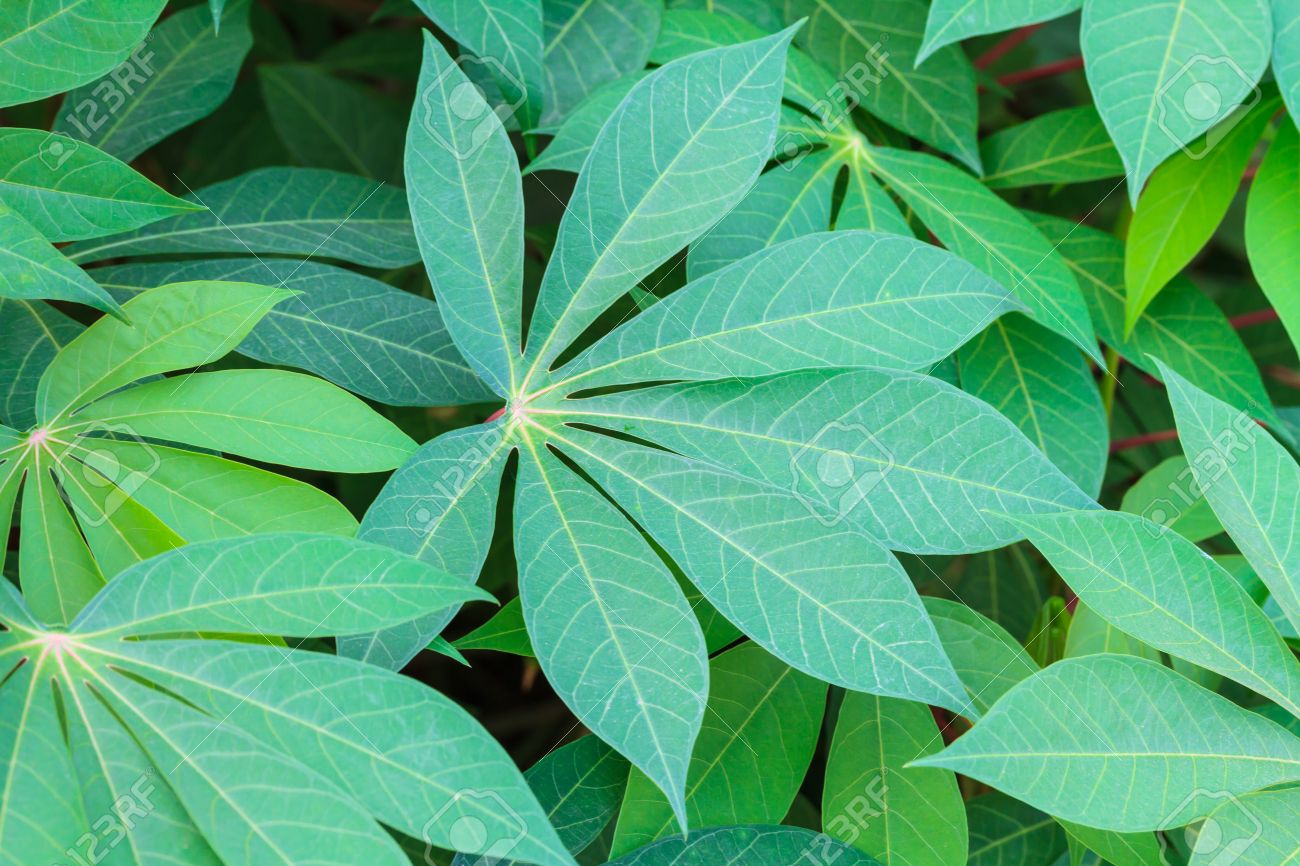

In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

### Load all the required libraries

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import keras
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from keras.models import Model
from keras import models, layers
from keras.optimizers import Adam 
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau, EarlyStopping
#from keras.applications.vgg19 import VGG19
from tensorflow.keras.applications import EfficientNetB4
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from PIL import Image
import os
import matplotlib.pyplot as plt

### Load the leaf dataset

In [ ]:
general_path = '../input/cassava-leaf-disease-classification/'

train = pd.read_csv(general_path + 'train.csv')
train['label'] = train['label'].astype('string')
train.sample(5)


In [ ]:
names_of_disease = pd.read_json(general_path + 'label_num_to_disease_map.json', typ='series')
names_of_disease

### Display random images

In [ ]:
plt.figure(figsize=(16, 12))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    image = Image.open(general_path + 'train_images/' + train.iloc[i]['image_id'])
    array = np.array(image)
    plt.imshow(array)
    label=train.iloc[i]['label']
    plt.title(f'{names_of_disease[int(label)]}')
plt.show()

### Resize the images

In [ ]:
sizes = []
for i in range(1, len(train), 250):
    image = Image.open(general_path + 'train_images/' + train.iloc[i]['image_id'])
    array = np.array(image)
    sizes.append(array.shape)
print('Picture size', set(sizes))

In [ ]:
img_width, img_height = 380, 380

### Data Augmentation

In [ ]:
datagen = ImageDataGenerator(validation_split=0.2,
                             rotation_range = 40,
                             width_shift_range = 0.2,
                             height_shift_range = 0.2,
                             shear_range = 0.2,
                             zoom_range = 0.2,
                             vertical_flip=True,
                             horizontal_flip=True)

train_datagen_flow = datagen.flow_from_dataframe(
    dataframe=train,
    directory=general_path + 'train_images',
    x_col='image_id',
    y_col='label',
    target_size=(img_width, img_height),
    batch_size=64,
    subset='training',
    seed=12345)


valid_datagen_flow = datagen.flow_from_dataframe(
    dataframe=train,
    directory=general_path + 'train_images',
    x_col='image_id',
    y_col='label',
    target_size=(img_width, img_height),
    batch_size=64,
    class_mode = 'categorical',
    subset='validation',
    seed=12345)

In [ ]:
current_balance = train['label'].value_counts(normalize=True)
current_balance

In [ ]:
class_weight = {0: (1 - current_balance[0]) / (1 - current_balance.min()),
                1: (1 - current_balance[1]) / (1 - current_balance.min()),
                2: (1 - current_balance[2]) / (1 - current_balance.min()),
                3: (1 - current_balance[3]) / (1 - current_balance.min()),
                4: (1 - current_balance[4]) / (1 - current_balance.min())}

class_weight

### Using EfficientNetB0 transfer learning to build a CNN model

In [ ]:
model =EfficientNetB4(include_top=False, input_shape=(128,128,3), weights=None, pooling='avg')
EfficientNet = "../input/tfkerasefficientnetimagenetnotop/efficientnetb4_notop.h5"
model.load_weights(EfficientNet)

model = models.Sequential()
model.add(layers.GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dense(256, activation = 'relu', bias_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.001)))
model.add(Dropout(0.5))
model.add(layers.Dense(5, activation = "softmax"))


In [ ]:
early_stop = EarlyStopping(monitor = "val_loss",
                                min_delta=0.001,
                                patience=3,
                                verbose=1,
                                mode="min",
                                #baseline=None,
                                restore_best_weights=False)

reduce_lr = ReduceLROnPlateau(monitor="val_loss",
                                factor=0.1,
                                patience=3,
                                verbose=1,
                                mode="min",
                                min_delta=0.0001)

optimizer = Adam(lr=0.001)

model.compile(loss="categorical_crossentropy", 
              optimizer=optimizer, 
              metrics=["accuracy"])

### Train the model

In [ ]:
history = model.fit_generator(train_datagen_flow,
                    validation_data=valid_datagen_flow, 
                    epochs=50,
                    callbacks=[early_stop, reduce_lr], 
                    use_multiprocessing=True,
                    shuffle=True,
                    verbose=2)

In [ ]:
model.save('Cassava_model'+'.h5') 

### Visualize loss and accuracy on training and test dataset

In [ ]:
def visualize_training(history, lw = 2):
    plt.figure(figsize=(10,10))
    plt.subplot(2,1,1)
    plt.plot(history.history['accuracy'], label = 'training', marker = '*', linewidth = lw)
    plt.plot(history.history['val_accuracy'], label = 'validation', marker = 'o', linewidth = lw, color='red')
    plt.title('Accuracy Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend(fontsize = 'x-large')
    

    plt.subplot(2,1,2)
    plt.plot(history.history['loss'], label = 'training', marker = '*', linewidth = lw)
    plt.plot(history.history['val_loss'], label = 'validation', marker = 'o', linewidth = lw, color='red')
    plt.title('Loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(fontsize = 'x-large')
    plt.grid(True)
    plt.show()

visualize_training(history)

In [ ]:
# Prediction accuracy on train data
score_tr = model.evaluate_generator(train_datagen_flow, verbose=1)
print("Prediction accuracy on train data =", score_tr[1])

# Prediction accuracy on test data
score_ts = model.evaluate_generator(valid_datagen_flow, verbose=1)
print("Prediction accuracy on test data =", score_ts[1])

### Prediction on test data

In [ ]:
submission = pd.DataFrame(columns=['image_id','label'])
for image_name in os.listdir(general_path + 'test_images'):
    image_path = os.path.join(general_path + 'test_images', image_name)
    image = keras.preprocessing.image.load_img(image_path)
    resized_image = image.resize((img_width, img_height))
    numpied_image = np.expand_dims(resized_image, 0)
    tensored_image = tf.cast(numpied_image, tf.float32)
    submission = submission.append(pd.DataFrame({'image_id': image_name,
                                                 'label': model.predict_classes(tensored_image)}))

submission

### Submission

In [ ]:
submission.to_csv('/kaggle/working/submission.csv', index=False)